<a href="https://colab.research.google.com/github/VegaMorenoAna/Prueba-Newtral/blob/main/AnaVegaMorenoPruebaNewtral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ana Vega Moreno**

En primer lugar instalamos las librerías que vamos a necesitar e importamos lo necesario de cada una de ellas.

In [1]:
pip install transformers numpy torch sklearn

In [2]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import random
import pandas as pd

Para que siempre aporte los mismos resultados creamos una función para fijar la semilla.

In [3]:
def set_seed(seed: int):
    """
    Función para fijar la semilla.

    Args:
        seed (:obj:`int`): Número que representa la semilla a fijar.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

set_seed(1)

Permito a google colab que acceda a mi drive, que es donde tengo los archivos csv.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MyDrive


In [5]:
# Cargamos los datos
train = pd.read_csv('/content/drive/MyDrive/webis_train.csv')
test = pd.read_csv('/content/drive/MyDrive/webis_test.csv')

In [6]:
# Muestro como vienen los datasets.
train.head(3)

,Unnamed: 0,postMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription,truthJudgments,truthMean,truthClass,truthMedian,truthMode
0,0,[],UK’s response to modern slavery leaving victim...,858462320779026432,['modern-slavery-rex.jpg'],['Thousands of modern slavery victims have\xa0...,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,"modern slavery, Department For Work And Pensio...",“Inexcusable” failures in the UK’s system for ...,"[0.33333333330000003, 0.0, 0.33333333330000003...",0.133333,no-clickbait,0.000000,0.000000
1,1,[],this is good,858421020331560960,"['In this July 1, 2010 file photo, Dr. Charmai...",['President Donald Trump has appointed the\xa0...,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,"Americans United for Life, Dr. Charmaine Yoest...",President Donald Trump has appointed pro-life ...,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,clickbait,1.000000,1.000000
2,2,[],"The ""forgotten"" Trump roast: Relive his brutal...",858368123753435136,"[""President Trump will not attend this year's ...",['When the\xa0White House correspondents’ dinn...,The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,"trump whcd, whcd, white house correspondents d...",President Trump won't be at this year's White ...,"[0.33333333330000003, 1.0, 0.33333333330000003...",0.466667,no-clickbait,0.333333,0.333333


In [7]:
test.head(3)

,Unnamed: 0,id,postMedia,targetCaptions,postText,postTimestamp,targetTitle,targetDescription,targetKeywords,targetParagraphs,truthJudgments,truthClass,truthMedian,truthMode,truthMean
0,0,858426904239497216,['media/photo_858425825229549568.jpg'],"['Cleveland Browns logo', 'Dec 6, 2015; Clevel...",Johnny Manziel on Browns' No. 1 pick Myles Gar...,Sat Apr 29 21:04:57 +0000 2017,Johnny Manziel Says Top Pick in Draft Myles Ga...,Johnny Manziel approves of the Cleveland ...,"NFL Draft, Football, NFL, AFC North, Cleveland...","[""Johnny Manziel approves of the Cleveland Bro...","[0.0, 0.0, 0.0, 0.0, 0.0]",no-clickbait,0.0,0.0,0.000000
1,1,858416350540201984,['media/photo_858416342268911616.jpg'],"['Five', 'Guilfoyle', 'Coulter', 'Cain']",Fabio: California Is a 'Mess' Because of Liber...,Sat Apr 29 20:23:01 +0000 2017,Fabio: California Is a 'Mess' Because of Liber...,"Fabio, the Italian-born male model who has ado...",NaN,"['Fabio, the Italian-born male model who has a...","[0.0, 0.0, 0.0, 0.33333333330000003, 0.0]",no-clickbait,0.0,0.0,0.066667
2,2,858364015260704768,[],[],"""He's been huge for us this year, man.""",Sat Apr 29 16:55:03 +0000 2017,"Jimmy Butler wants to return, hopes Bulls keep...",Bulls guard Jimmy Butler says he wants to rema...,"guards, backcourt, option, contract, Chicago B...","[""CHICAGO -- All-Star swingman Jimmy Butler kn...","[1.0, 1.0, 1.0, 1.0, 1.0]",clickbait,1.0,1.0,1.000000


In [8]:
# Formato de los datos
print(type(train))
print(type(test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [9]:
# Comprobamos cuantas filas y cuantas columnas contiene train
print("El dataframe contiene un total de {} filas".format(len(train)))
print("El dataframe contiene un total de {} columnas".format(train.shape[1]))
# Las filas también podrían calcularse de la siguiente manera
print("El dataframe contiene un total de {} filas".format(train.shape[0]))

El dataframe contiene un total de 19538 filas
El dataframe contiene un total de 15 columnas
El dataframe contiene un total de 19538 filas


In [10]:
# Comprobamos cuantas filas y cuantas columnas contiene test
print("El dataframe contiene un total de {} filas".format(len(test)))
print("El dataframe contiene un total de {} columnas".format(test.shape[1]))
# Las filas también podrían calcularse de la siguiente manera
print("El dataframe contiene un total de {} filas".format(test.shape[0]))

El dataframe contiene un total de 18979 filas
El dataframe contiene un total de 15 columnas
El dataframe contiene un total de 18979 filas


In [11]:
# Comprobamos si existen duplicados en train
print("Existen {} documentos duplicadas".format(np.sum(train.duplicated(subset=["postText"]))))

Existen 456 documentos duplicadas


In [12]:
# Quitaremos esos duplicados
train = train.drop_duplicates(subset=["postText"])
print("Después de quitar duplicados tenemos un conjunto de {} post".format(train.shape[0]))

Después de quitar duplicados tenemos un conjunto de 19082 post


In [13]:
# Comprobamos si existen duplicados en test
print("Existen {} documentos duplicadas".format(np.sum(test.duplicated(subset=["postText"]))))

Existen 445 documentos duplicadas


In [14]:
# Quitaremos esos duplicados
test = test.drop_duplicates(subset=["postText"])
print("Después de quitar duplicados tenemos un conjunto de {} post".format(test.shape[0]))

Después de quitar duplicados tenemos un conjunto de 18534 post


In [15]:
train.columns.values

array(['Unnamed: 0', 'postMedia', 'postText', 'id', 'targetCaptions',
       'targetParagraphs', 'targetTitle', 'postTimestamp',
       'targetKeywords', 'targetDescription', 'truthJudgments',
       'truthMean', 'truthClass', 'truthMedian', 'truthMode'],
      dtype=object)

In [16]:
train = train.drop(['Unnamed: 0', 'postMedia', 'id', 'targetCaptions',
                    'targetParagraphs', 'targetTitle', 'postTimestamp',
                    'targetKeywords', 'targetDescription', 'truthJudgments',
                    'truthMean', 'truthMedian', 'truthMode'], axis=1)

In [17]:
train.head(3)

,postText,truthClass
0,UK’s response to modern slavery leaving victim...,no-clickbait
1,this is good,clickbait
2,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait


In [18]:
# Comprobamos si existen valores vacios en train 
print("Hay {} valores vacíos en postText y {} valores vacíos en las etiquetas en los datos".format(np.sum(train.isnull())[0],
                                                                                                   np.sum(train.isnull())[1]))

Hay 1 valores vacíos en postText y 0 valores vacíos en las etiquetas en los datos


In [19]:
train = train.dropna()

In [20]:
# Comprobamos  que se han eliminado
print("Hay {} valores vacíos en postText y {} valores vacíos en las etiquetas en los datos".format(np.sum(train.isnull())[0],
                                                                                                   np.sum(train.isnull())[1]))

Hay 0 valores vacíos en postText y 0 valores vacíos en las etiquetas en los datos


In [21]:
test.columns.values

array(['Unnamed: 0', 'id', 'postMedia', 'targetCaptions', 'postText',
       'postTimestamp', 'targetTitle', 'targetDescription',
       'targetKeywords', 'targetParagraphs', 'truthJudgments',
       'truthClass', 'truthMedian', 'truthMode', 'truthMean'],
      dtype=object)

In [22]:
test = test.drop(['Unnamed: 0', 'id', 'postMedia', 'targetCaptions',
                    'postTimestamp', 'targetTitle', 'targetDescription',
                    'targetKeywords', 'targetParagraphs', 'truthJudgments',
                    'truthMedian', 'truthMode', 'truthMean'], axis=1)

In [23]:
test.head(3)

,postText,truthClass
0,Johnny Manziel on Browns' No. 1 pick Myles Gar...,no-clickbait
1,Fabio: California Is a 'Mess' Because of Liber...,no-clickbait
2,"""He's been huge for us this year, man.""",clickbait


In [24]:
# Comprobamos si existen valores vacios en test 
print("Hay {} valores vacíos en postText y {} valores vacíos en las etiquetas en los datos".format(np.sum(test.isnull())[0],
                                                                                                   np.sum(test.isnull())[1]))

Hay 1 valores vacíos en postText y 0 valores vacíos en las etiquetas en los datos


In [25]:
test = test.dropna()

In [26]:
# Comprobamos  que se han eliminado
print("Hay {} valores vacíos en postText y {} valores vacíos en las etiquetas en los datos".format(np.sum(test.isnull())[0],
                                                                                                   np.sum(test.isnull())[1]))

Hay 0 valores vacíos en postText y 0 valores vacíos en las etiquetas en los datos


In [27]:
# Comprobamos cuantas etiquetas hay de cada clase, para ver si está balanceado o no
pd.value_counts(train['truthClass'])

no-clickbait    14544
clickbait        4537
Name: truthClass, dtype: int64

Vemos que no está balanceado, esto implica que podrá darnos problemas de entrenamiento, pero esto sucede en la mayoría de casos. 
A continuación se muestra un gráfico de dicho desvalanceo.

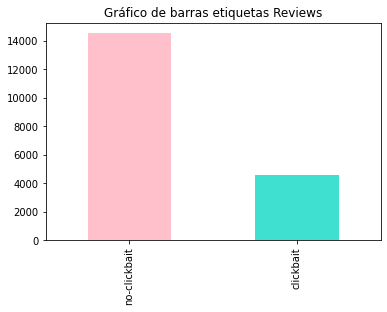

In [28]:
import matplotlib.pyplot as plt
ax, fig = plt.subplots()
etiquetas = pd.value_counts(train['truthClass']) # Número de etiquetas de cada clase
etiquetas.plot(kind= 'bar', color= ["pink", "turquoise"]) # bar es que es tipo histograma
plt.title('Gráfico de barras etiquetas Reviews')
plt.show()

In [29]:
train['truthClass'].unique()

array(['no-clickbait', 'clickbait'], dtype=object)

In [30]:
# Cambio las etiquetas de los datos, donde antes era no-clickbait ahora será 0 y clickbait será 1.
train['truthClass'] = train['truthClass'].map({'no-clickbait':0, 'clickbait':1}, na_action=None)
test['truthClass'] = test['truthClass'].map({'no-clickbait':0, 'clickbait':1}, na_action=None)

In [31]:
train.head(3)

,postText,truthClass
0,UK’s response to modern slavery leaving victim...,0
1,this is good,1
2,"The ""forgotten"" Trump roast: Relive his brutal...",0


In [32]:
# Creo una lista con las etiquetas
target_names = ['no-clickbait', 'clickbait']

In [33]:
# Hago varias transformaciones para obtener el formato que necesito
train_texts = train['postText'].to_list()
valid_texts = test['postText'].to_list()
train_labels = train['truthClass'].to_list()
valid_labels = test['truthClass'].to_list()

In [34]:
train_labels = np.array(train_labels,)
valid_labels = np.array(valid_labels,)

En primer lugar el modelo que vamos a usar es el "bert-base-uncased", el cual es un modelo preentrenado en inglés.

In [35]:
model_name1 = "bert-base-uncased"

Primero dividiremos nuestras oraciones en tokens, es decir, en unidades de texto mínimas, todas las palabras así como determinantes, preposiciones, iconos si los hubiese, etcetera.

In [36]:
# Usamos un tokenizador para poder dividir las secuencias en tokens
tokenizer = BertTokenizerFast.from_pretrained(model_name1, do_lower_case=True)
# do_lower_case = True para escribir en minúsculas todo el texto 

In [37]:
# Ahora usamos el tokenizador para nuestro corpus.
train_encodings = tokenizer(train_texts, padding=True)
valid_encodings = tokenizer(valid_texts, padding=True)
# Puesto que no he usado max_length tomará aquel texto que tenga longitud maxima
# por ello padding = True para que rellene con fichas vacías aquellos que son menores que diche longitud

In [38]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convierte los datos tokenizados en un torch dataset
# ya que para usar transformers se necesita formato torch 
train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)

In [39]:
# Cargo el modelo y sus pesos pre-entrenados
model1 = BertForSequenceClassification.from_pretrained(model_name1, num_labels=len(target_names))
# num_labels, es el número de clases que tiene nuetra variable objetivo

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [40]:
# Función para calcuular la métrica que deseamos, en este caso solo la accuracy
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calcula la accuraccy 
  acc = accuracy_score(labels, preds)
  # calcula la matriz de confusión
  recall = recall_score(labels, preds)
  precision = precision_score(labels, preds)
  f1 = f1_score(labels, preds)
  return {
      'accuracy': acc,
      'recall': recall,
      'precision' : precision,
      'f1': f1,
  }

In [41]:
# Especificamos nuestros argumentos de entrenamiento
training_args1 = TrainingArguments(
    output_dir='./results',          # directorio de salida
    num_train_epochs=1,              # número de veces que se repiten los datos de entrenamiento
    per_device_train_batch_size=4,  # tamaño del lote durante entrenamiento
    per_device_eval_batch_size=8,   # tamaño del lote para evaluación
    warmup_steps=100,                # número de pasos para la tasa de aprendizaje
    weight_decay=0.01,               # evita que los pesos se hagan demasiado grandes
    logging_dir='./logs',            # directorio para guardar registros
    load_best_model_at_end=True,     # carga el mejor modelo cuando finaliza el entrenamiento (metrica por defecto es loss)
    # pero puede especificar `metric_for_best_model` para cambiar a accuracy u otra métrica.
    logging_steps=800,               # registrar y guardar pesos cada logging_steps
    save_steps=800,
    evaluation_strategy="steps",     # evaluar cada `logging_steps`
)

In [42]:
trainer1 = Trainer(
    model=model1,                         # modelo a entrenar
    args=training_args1,                  # argumentos sobre los que se va a entrenar
    train_dataset=train_dataset,         # dataset de entrenamiento
    eval_dataset=valid_dataset,          # dataset de evaluación
    compute_metrics=compute_metrics,     # calcula las métricas de intereés
)

In [43]:
# Entrenamiento del modelo
trainer1.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 19081
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 4771


Step,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
800,0.535800,0.464216,0.853181,0.513130,0.779111,0.618747
1600,0.546800,0.421065,0.845033,0.709040,0.653179,0.679964
2400,0.504800,0.421549,0.820267,0.770160,0.585926,0.665529
3200,0.501800,0.483641,0.861490,0.604462,0.750433,0.669584
4000,0.453900,0.449530,0.857983,0.541018,0.779899,0.638858


***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-800
Configuration saved in ./results/checkpoint-800/config.json
Model weights saved in ./results/checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1600
Configuration saved in ./results/checkpoint-1600/config.json
Model weights saved in ./results/checkpoint-1600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-2400
Configuration saved in ./results/checkpoint-2400/config.json
Model weights saved in ./results/checkpoint-2400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-3200
Configuration saved in ./results/checkpoint-3200/config.json
Model weights saved in ./results/checkpoint-3200/pytorch_model

TrainOutput(global_step=4771, training_loss=0.5015093632100188, metrics={'train_runtime': 865.8953, 'train_samples_per_second': 22.036, 'train_steps_per_second': 5.51, 'total_flos': 1019773228362720.0, 'train_loss': 0.5015093632100188, 'epoch': 1.0})

'Training loss' indica qué tan bien se ajusta el modelo a los datos de entrenamiento, mientras que 'Validation loss' indica qué tan bien se ajusta el modelo a los datos nuevos. Estos valores tienen que decrecer puesto que estos algoritmos se basan en el descenso de gradiente, no se consigue gran mejora con respecto a la primera iteración.

In [44]:
# Evaluamos el mejor modelo obtenido después del entrenamiento
trainer1.evaluate()

***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8


{'epoch': 1.0,
 'eval_accuracy': 0.8450331840500729,
 'eval_f1': 0.6799643414308001,
 'eval_loss': 0.42106515169143677,
 'eval_precision': 0.653179190751445,
 'eval_recall': 0.7090402045084825,
 'eval_runtime': 55.304,
 'eval_samples_per_second': 335.111,
 'eval_steps_per_second': 41.896}

La evaluación se realiza sobre el mejor modelo obtenido anteriormente.

Hemos evaluado distintas métricas, como se trata de un dataset con datos muy desbalanceados no nos bastará con mirar la accuracy, pues esta medida solo tiene en cuenta el número de aciertos, pero esto para clases desbalanceadas no es lo idóneo, puesto que puede predcir a la perfección la clase mayoritaria, pero por el contrario no predecir en absoluto la clase minoritaria.
Esto no nos sirve porque un modelo que nos diga que todas las noticias no son clickbait no nos sirve en absoluto. 

Tendríamos que tener en cuenta recall y precision.

Si tenemos:

* Alta precision y alto recall, el modelo maneja perfectamente esa clase.
* Alta precision y bajo recall el modelo no detecta la clase muy bien, pero cuando lo hace es confiable.
* Baja precision y alto recall, detecta bien la clase, pero también incluye muestras de la otra clase.
* Baja precision y bajo recall el modelo no logra clasificar la clase correctamente.

En este caso hemos obtenido con el mejor modelo:

* precision =  0.7462648119526017
* recall = 0.6385276614502976

Vemos que no son valores extremadamente bajos, pero tampoco son altos, por lo que nuestro modelo no está pudiendo clasificar la clase tan bien como desearíamos.

In [45]:
# Especificamos nuevos argumentos de entrenamiento
training_args2 = TrainingArguments(
    output_dir='./results',          # directorio de salida
    num_train_epochs=2,              # número de veces que se repiten los datos de entrenamiento
    per_device_train_batch_size=8,  # tamaño del lote durante entrenamiento
    per_device_eval_batch_size=8,   # tamaño del lote para evaluación
    warmup_steps=200,                # número de pasos para la tasa de aprendizaje
    weight_decay=0.01,               # evita que los pesos se hagan demasiado grandes
    logging_dir='./logs',            # directorio para guardar registros
    load_best_model_at_end=True,     # carga el mejor modelo cuando finaliza el entrenamiento (metrica por defecto es loss)
    # pero puede especificar `metric_for_best_model` para cambiar a accuracy u otra métrica.
    logging_steps=600,               # registrar y guardar pesos cada logging_steps
    save_steps=600,
    evaluation_strategy="steps",     # evaluar cada `logging_steps`
)

using `logging_steps` to initialize `eval_steps` to 600
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [46]:
trainer2 = Trainer(
    model=model1,                         # modelo a entrenar
    args=training_args2,                  # argumentos sobre los que se va a entrenar
    train_dataset=train_dataset,         # dataset de entrenamiento
    eval_dataset=valid_dataset,          # dataset de evaluación
    compute_metrics=compute_metrics,     # calcula las métricas de intereés
)

In [47]:
# Entrenamiento del modelo
trainer2.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 19081
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4772


Step,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
600,0.392800,0.393499,0.856580,0.610969,0.727650,0.664224
1200,0.419700,0.428138,0.846004,0.432721,0.818462,0.566130
1800,0.422500,0.351250,0.848055,0.474785,0.786072,0.592002
2400,0.392500,0.388457,0.853720,0.715547,0.674332,0.694329
3000,0.355400,0.424882,0.849566,0.590286,0.712482,0.645653
3600,0.357300,0.409812,0.858415,0.682779,0.700024,0.691294
4200,0.331000,0.414508,0.859602,0.650709,0.718133,0.682760


***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-600
Configuration saved in ./results/checkpoint-600/config.json
Model weights saved in ./results/checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1200
Configuration saved in ./results/checkpoint-1200/config.json
Model weights saved in ./results/checkpoint-1200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1800
Configuration saved in ./results/checkpoint-1800/config.json
Model weights saved in ./results/checkpoint-1800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-2400
Configuration saved in ./results/checkpoint-2400/config.json
Model weights saved in ./results/checkpoint-2400/pytorch_model

TrainOutput(global_step=4772, training_loss=0.3754251612801564, metrics={'train_runtime': 1256.2399, 'train_samples_per_second': 30.378, 'train_steps_per_second': 3.799, 'total_flos': 2039546456725440.0, 'train_loss': 0.3754251612801564, 'epoch': 2.0})

In [48]:
# Evaluamos el mejor modelo obtenido después del entrenamiento
trainer2.evaluate()

***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8


{'epoch': 2.0,
 'eval_accuracy': 0.8480548211298764,
 'eval_f1': 0.5920023181686467,
 'eval_loss': 0.35125017166137695,
 'eval_precision': 0.7860715659869181,
 'eval_recall': 0.4747850336974204,
 'eval_runtime': 55.081,
 'eval_samples_per_second': 336.468,
 'eval_steps_per_second': 42.065}

En esta ocasión al variar los parámetros hemos tardado más tiempo en el entrenamiento.
Al aumentar el número de 'epoch', se obtiene un mejor entrenamiento.
Se ha disminuido el número de pasos tras los que se evalua y guarda el modelo, disminuyendo, hacemos que se evalúe y guarde más veces el modelo, ya que lo hace cada menos pasos, debido a esto también se ha aumentado el tiempo de cómputo.

Se puede comprobar como variando los parámetros podríamos seguir mejorando el modelo, para ello deberíamos aumentar el número de 'epoch', así como aumentar el tamaño del batch y también disminuir aún más los pasos tras los que se evalua y guarda el modelo, pero debido a la falta de GPU y disponibilidad de google colab esto no ha sido posible.

En esta ocasión hemos obtenido:

* precision =  0.8852848101265823
* recall =  0.7399162442142385

Por lo que hemos conseguido mejorar el modelo, pero aún habría bastantes valores a los que no detecta la clase bien.

Precision puede considerarse alta, pero recall no sería tan alta como deseríamos por lo que podría decirse que no detecta la clase muy bien pero cuando lo hace es confiable.

Considero que lo solicitado ha sido realizado obteniendo bastante buenos resultados, ya que se pidió un modelo de detección de clickbait en tweets, utilizando la técnica de fine-tuning de un modelo pre-entrenado de tipo BERT y se ha realizado correctamente.

Aunque me hubiese gustado poder probar más modelo, así como poder variar más los parámetros para intentar conseguir mejorar los parámetros y conseguir mejores resultados, cosa que no ha podido realizarse debido a las disponibilidades de GPU de google colab free.

Trabajando con el dataset tal cuál podríamos intentar mejorar los valores tuneando los parámetros, pero aunque así fuese no conseguiríamos un modelo tan confiable como para fiarnos de los resultados obtenidos, y esto es debido al desbalanceo entre clases.

Para poder solucionar este problema, lo que tendríamos que realizar es alguna de las técnicas para balancear el dataset.

Existen diferentes técnicas para ello, basandose algunas de ellas en la creación de nuevos datos para poder igualar las clases, o el caso contrario, el cual se trataría de eliminar datos de la clase mayoritaria para así poder obtener unn dataset balanceado.

In [49]:
# Ordenamos el dataset train
train_ordered = train.sort_values('truthClass',ascending = False, ignore_index = True)
train_ordered.head(100)

,postText,truthClass
0,So when exactly does the New Year begin in space?,1
1,Time to start doing your homework:,1
2,The earbuds of the future will let you control...,1
3,So the (basically) official Arthur Twitter jus...,1
4,They were hoping to get to the US -- and then ...,1
...,...,...
95,Is this the mobile home for the apocalypse?,1
96,"30 years later, the creepy Max Headroom broadc...",1
97,Here are the best titles coming to Netflix in ...,1
98,Women flood Twitter with stories of the first ...,1


In [50]:
pd.value_counts(train_ordered['truthClass'])

0    14544
1     4537
Name: truthClass, dtype: int64

In [51]:
train_ordered

,postText,truthClass
0,So when exactly does the New Year begin in space?,1
1,Time to start doing your homework:,1
2,The earbuds of the future will let you control...,1
3,So the (basically) official Arthur Twitter jus...,1
4,They were hoping to get to the US -- and then ...,1
...,...,...
19076,"""Tasty the Cookbook"" has been a huge hit for @...",0
19077,Five races to watch during Sunday’s Golden Glo...,0
19078,Queen appears in public for first time in a mo...,0
19079,"The long, hard road to repealing Obamacare is ...",0


In [52]:
train_balanceado = train_ordered.drop(range(9073,19080),axis=0)

In [53]:
train_balanceado

,postText,truthClass
0,So when exactly does the New Year begin in space?,1
1,Time to start doing your homework:,1
2,The earbuds of the future will let you control...,1
3,So the (basically) official Arthur Twitter jus...,1
4,They were hoping to get to the US -- and then ...,1
...,...,...
9069,NFL denies barring Lady Gaga from talking poli...,0
9070,White House press secretary Josh Earnest: The ...,0
9071,"Seeing a lot of pink hats today? The ""Pussyhat...",0
9072,People with high emotional intelligence are ma...,0


In [54]:
pd.value_counts(train_balanceado['truthClass'])

1    4537
0    4537
Name: truthClass, dtype: int64

Ahora ya tenemos un datset totalmente balanceado, por lo que procederemos a realizar los mismo cálculos realizados anteriormente.

Al conjunto de test no le realizamos de balanceo, pues no es necesario, ya que con ellos no estamos entrenando el modelo, solo lo evaluaríamos.

In [55]:
# Hago varias transformaciones para obtener el formato que necesito
train_texts = train_balanceado['postText'].to_list()
train_labels = train_balanceado['truthClass'].to_list()

In [56]:
train_labels = np.array(train_labels,)

Realizo todos los pasos de nuevo, pero para nuestro nuevo conjunto de entrenamiento.

In [57]:
# Ahora usamos el tokenizador para nuestro corpus.
train_encodings = tokenizer(train_texts, padding=True)
valid_encodings = tokenizer(valid_texts, padding=True)
# Puesto que no he usado max_length tomará aquel texto que tenga longitud maxima
# por ello padding = True para que rellene con fichas vacías aquellos que son menores que diche longitud

In [58]:
# convierte los datos tokenizados en un torch dataset
# ya que para usar transformers se necesita formato torch 
train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)

In [59]:
trainer3 = Trainer(
    model=model1,                         # modelo a entrenar
    args=training_args1,                  # argumentos sobre los que se va a entrenar
    train_dataset=train_dataset,         # dataset de entrenamiento
    eval_dataset=valid_dataset,          # dataset de evaluación
    compute_metrics=compute_metrics,     # calcula las métricas de intereés
)

In [60]:
# Entrenamiento del modelo
trainer3.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9074
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 2269


Step,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
800,0.596300,0.435796,0.846652,0.631885,0.683681,0.656763
1600,0.585600,0.529458,0.849943,0.484313,0.787604,0.599799


***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-800
Configuration saved in ./results/checkpoint-800/config.json
Model weights saved in ./results/checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1600
Configuration saved in ./results/checkpoint-1600/config.json
Model weights saved in ./results/checkpoint-1600/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-800 (score: 0.4357962906360626).


TrainOutput(global_step=2269, training_loss=0.5752434089563133, metrics={'train_runtime': 391.6838, 'train_samples_per_second': 23.167, 'train_steps_per_second': 5.793, 'total_flos': 484954786130880.0, 'train_loss': 0.5752434089563133, 'epoch': 1.0})

In [61]:
# Evaluamos el mejor modelo obtenido después del entrenamiento
trainer3.evaluate()

***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8


{'epoch': 1.0,
 'eval_accuracy': 0.8466519181999677,
 'eval_f1': 0.6567632850241546,
 'eval_loss': 0.4357962906360626,
 'eval_precision': 0.6836811667085743,
 'eval_recall': 0.6318847315826168,
 'eval_runtime': 55.1143,
 'eval_samples_per_second': 336.265,
 'eval_steps_per_second': 42.04}

In [62]:
trainer4 = Trainer(
    model=model1,                         # modelo a entrenar
    args=training_args2,                  # argumentos sobre los que se va a entrenar
    train_dataset=train_dataset,         # dataset de entrenamiento
    eval_dataset=valid_dataset,          # dataset de evaluación
    compute_metrics=compute_metrics,     # calcula las métricas de intereés
)

In [63]:
# Entrenamiento del modelo
trainer4.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9074
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2270


Step,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
600,0.440100,0.529372,0.816705,0.821055,0.573539,0.675332
1200,0.453500,0.443358,0.840501,0.778527,0.625817,0.693869
1800,0.406700,0.462056,0.842659,0.745062,0.638010,0.687393


***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-600
Configuration saved in ./results/checkpoint-600/config.json
Model weights saved in ./results/checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1200
Configuration saved in ./results/checkpoint-1200/config.json
Model weights saved in ./results/checkpoint-1200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1800
Configuration saved in ./results/checkpoint-1800/config.json
Model weights saved in ./results/checkpoint-1800/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-1200 (score: 0.44335779547691345).


TrainOutput(global_step=2270, training_loss=0.43009160919861644, metrics={'train_runtime': 578.5731, 'train_samples_per_second': 31.367, 'train_steps_per_second': 3.923, 'total_flos': 969909572261760.0, 'train_loss': 0.43009160919861644, 'epoch': 2.0})

In [64]:
# Evaluamos el mejor modelo obtenido después del entrenamiento
trainer4.evaluate()

***** Running Evaluation *****
  Num examples = 18533
  Batch size = 8


{'epoch': 2.0,
 'eval_accuracy': 0.8405007284303675,
 'eval_f1': 0.6938690969345485,
 'eval_loss': 0.44335779547691345,
 'eval_precision': 0.6258172987110032,
 'eval_recall': 0.7785266093423193,
 'eval_runtime': 54.8124,
 'eval_samples_per_second': 338.117,
 'eval_steps_per_second': 42.271}